In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime

%matplotlib inline
pd.options.display.max_columns = None

In [2]:
data = pd.read_excel('/home/haomiao/scratch/Target0/data/All AIRSWEB Data 1st Jan 2015 -26 March 18.xlsx')

In [3]:
#add year, month, weekday, time for analysis
data['date_reported'] = data['Date/Time Reported'].dt.date
data['date_happened'] = data['Date/time of incident'].dt.date
data['weekday_reported'] = [calendar.day_name[c.weekday()] for c in data['date_reported']]
data['month_reported'] = [calendar.month_name[c.month] for c in data['date_reported']]
data['year_reported'] = [c.year for c in data['date_reported']]
data['time_reported'] = [datetime.datetime.time(c) for c in data['Date/Time Reported']]

data['weekday_happened'] = [calendar.day_name[c.weekday()] for c in data['date_happened']]
data['month_happened'] = [calendar.month_name[c.month] for c in data['date_happened']]
data['year_happened'] = [c.year for c in data['date_happened']]
data['time_happened'] = [datetime.datetime.time(c) for c in data['Date/time of incident']]
data['hour_of_day_happened'] = [c.hour for c in data['time_happened']]

data['year_month'] = data['date_happened'].map(lambda x: x.strftime('%y-%m'))

In [4]:
#check which columns are totally empty
empty_columns = []
for c in data.columns:
    if len(data[c].isnull().unique()) == 1 & data[c].isnull().unique()[0]:
        empty_columns.append(c)
    else:
        continue

empty_columns: 'Illness Type', 'If positive, for what?'

In [5]:
#check sparsity for all columns
sparsity = pd.DataFrame()
for c in data.columns:
    s = ((data[c].isnull().sum()/len(data[c]))*100).round(2)
    sparsity[c] = [s]

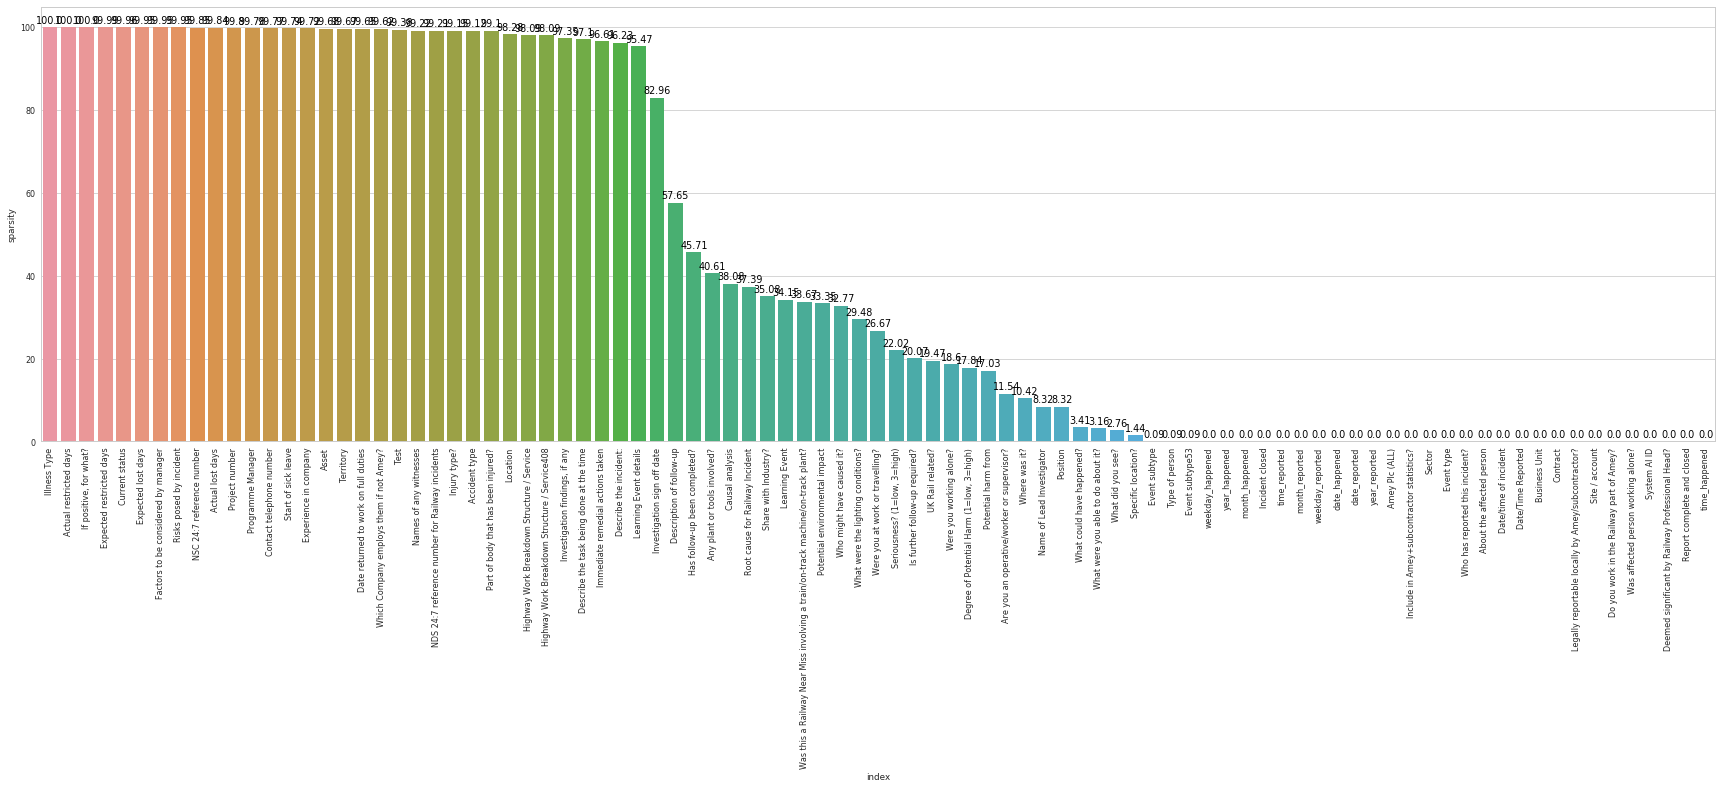

Columns with sparsity less than 10%:  ['Name of Lead Investigator' 'Position' 'What could have happened?'
 'What were you able to do about it?' 'What did you see?'
 'Specific location?' 'Event subtype' 'Type of person' 'Event subtype53'
 'weekday_happened' 'year_happened' 'month_happened' 'Incident closed'
 'time_reported' 'month_reported' 'weekday_reported' 'date_happened'
 'date_reported' 'year_reported' 'Amey Plc (ALL)'
 'Include in Amey+subcontractor statistics?' 'Sector' 'Event type'
 'Who has reported this incident?' 'About the affected person'
 'Date/time of incident' 'Date/Time Reported' 'Business Unit' 'Contract'
 'Legally reportable locally by Amey/subcontractor?' 'Site / account'
 'Do you work in the Railway part of Amey?'
 'Was affected person working alone?' 'System AI ID'
 'Deemed significant by Railway Professional Head?'
 'Report complete and closed' 'time_happened']


In [145]:
sns.set_color_codes('pastel')
ax = plt.figure(figsize = (30,8))

s = sparsity.T.reset_index()
s.rename(columns = {0:'sparsity'},inplace = True)
s.sort_values(['sparsity'],ascending = False, inplace = True)
s.reset_index(inplace = True)
g = sns.barplot(x = 'index', y ='sparsity', data = s)#, order = s.sort_values(['sparsity'],ascending = False)['index'].tolist())
for index, row in s.iterrows():   
    g.text(index,row.sparsity+1, str(row.sparsity), color='black', ha="center")

plt.xticks(rotation = 90)
plt.show()

print('Columns with sparsity less than 10%: ',  s.loc[s['sparsity'] <= 10.00]['index'].unique())


In [195]:
column_list = ['Describe the incident:',
               'What did you see?', 
               'What could have happened?',
               'What were you able to do about it?',
               'Immediate remedial actions taken',
               'Investigation findings, if any',
               'Description of follow-up',
               'Learning Event details',
               'Risks posed by incident',
               'Factors to be considered by manager']

selected = s[s['index'].isin(column_list)]
selected.sort_values(['sparsity'],ascending = True, inplace = True)
selected['index']

/home/haomiao/python_venv/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


58                      What did you see?
57     What were you able to do about it?
56              What could have happened?
34               Description of follow-up
32                 Learning Event details
31                 Describe the incident:
30       Immediate remedial actions taken
28         Investigation findings, if any
6     Factors to be considered by manager
7                 Risks posed by incident
Name: index, dtype: object

In [7]:
# empty: 0, has value: 1
column_corr = data.isnull()
for c in column_corr.columns:
    column_corr[c] = column_corr[c].map({False:1 , True:0})

#reorder columns by sparsity
order = s.sort_values(['sparsity'],ascending = False)['index'].tolist()
df = column_corr[order]

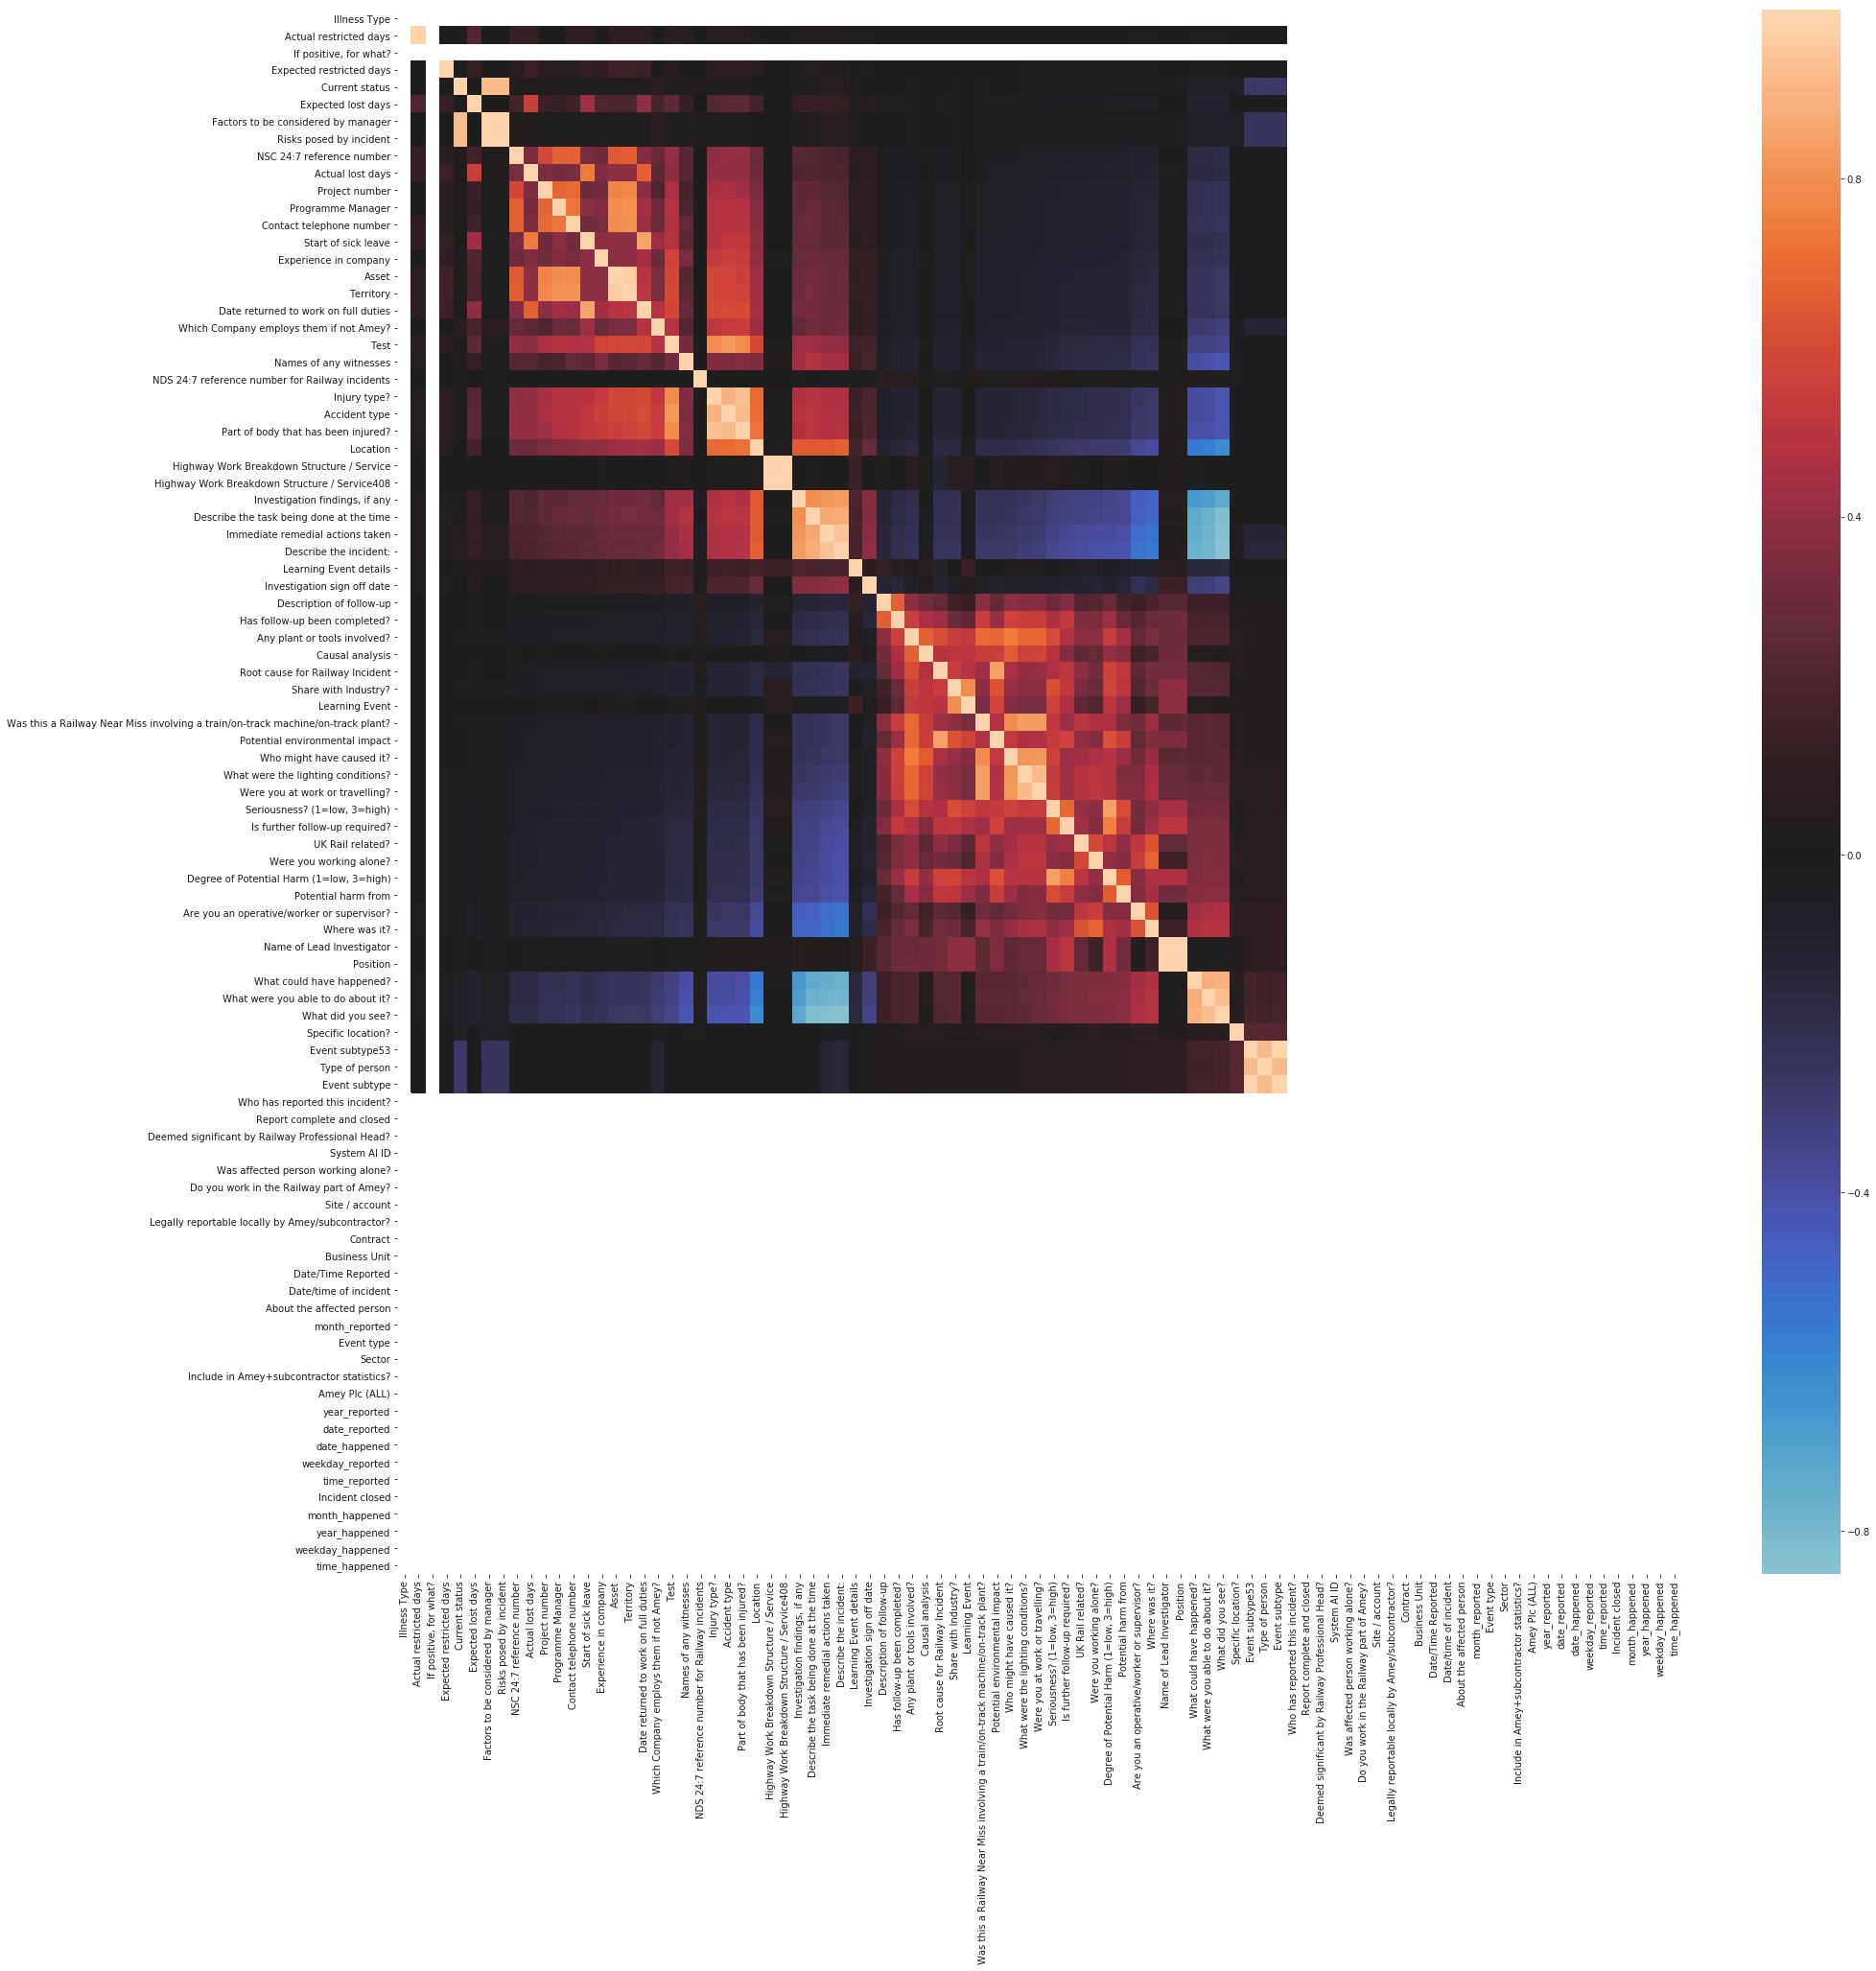

In [8]:
corr = df.corr()
#plot the heatmap
ax = plt.figure(figsize = (30,30))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels= corr.columns,center = 0)#, cmap="YlGnBu"

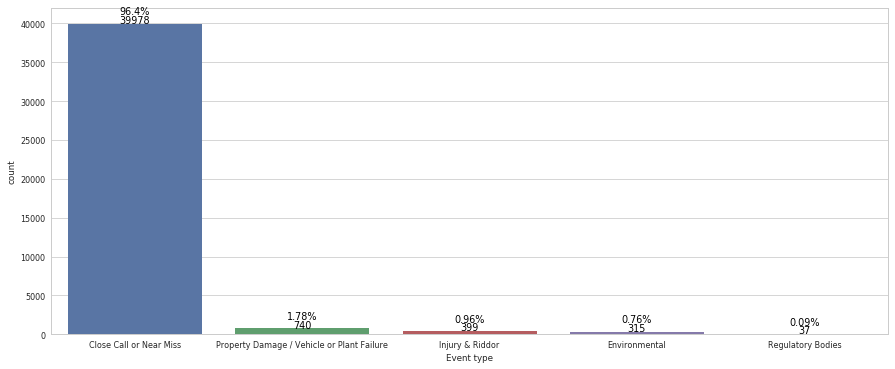

In [17]:
#Count of event type 
ax = plt.figure(figsize = (15,6))
g = sns.countplot(x='Event type', data = data)
#ax.set_xticklabels(ax2.get_xticklabels(),rotation=45)
#plt.xticks(rotation = 90)
c = data['Event type'].value_counts().reset_index()
t = data['Event type'].value_counts().sum() # total number of event
for index, row in c.iterrows():
    g.text(index, row['Event type'] + 100, str(row['Event type']), color = 'black', ha = 'center')
    g.text(index,row['Event type']+1200, str(((row['Event type']/t)*100).round(2))+'%', color='black', ha="center")
plt.show()


In [38]:
# daily numbers of different event
#get dataframe of daily event count
timeorder = data['date_reported'].unique()
timeorder.sort()

EventType = data.groupby(['year_reported','month_reported','date_reported','Event type']).size()
EventType = pd.DataFrame({'count' : EventType}).reset_index()
EventType.rename(columns ={'Event type':'event_type'},inplace = True)

In [39]:
EventTypeOthers = EventType.loc[EventType['event_type'] != 'Close Call or Near Miss']

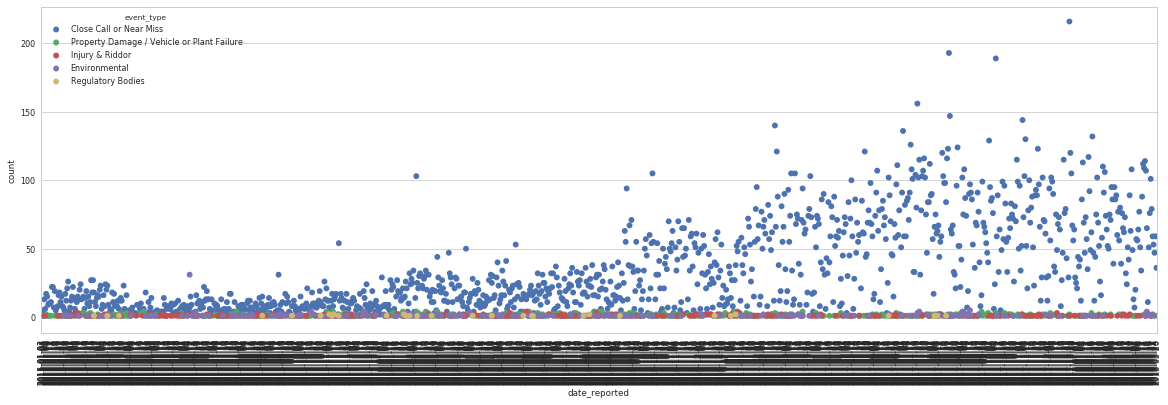

In [40]:
#plot daily event count
sns.set(style="whitegrid")                                                 
# make the size of point and line smaller 
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 1}                  
sns.set_context("paper", rc = paper_rc)                                    

ax = plt.figure(figsize = (20,6))
sns.pointplot(x='date_reported', y = 'count',
              data = EventType, hue ='event_type', join = False,
              order = timeorder)
#ax.set_xticklabels(ax2.get_xticklabels(),rotation=45)
plt.xticks(rotation = 90)
plt.show()

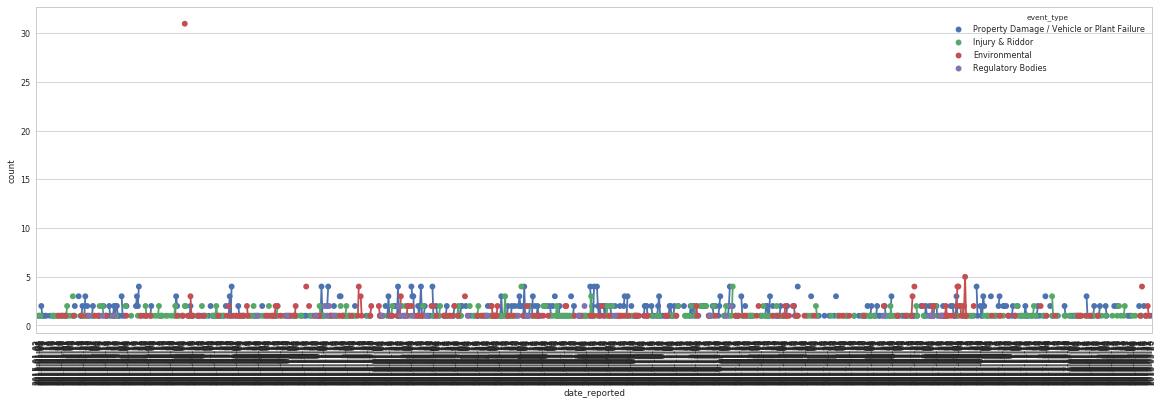

In [41]:
ax = plt.figure(figsize = (20,6))
sns.pointplot(x='date_reported', y = 'count',# estimator = sum,
              data = EventTypeOthers, hue ='event_type', 
              order = timeorder)
#ax.set_xticklabels(ax2.get_xticklabels(),rotation=45)
plt.xticks(rotation = 90)
plt.show()

In [13]:
data['Event type'].value_counts().reset_index()

,index,Event type
0,Close Call or Near Miss,39978
1,Property Damage / Vehicle or Plant Failure,740
2,Injury & Riddor,399
3,Environmental,315
4,Regulatory Bodies,37


In [18]:
#daily reported real incidents
EventTypeOthersSum = EventTypeOthers.pivot_table(values = 'count', index = 'date_reported', columns = 'event_type', aggfunc = 'sum', fill_value = 0) 
EventTypeOthersSum['sum'] = EventTypeOthersSum[list(EventTypeOthersSum.columns)].sum(axis = 1)
#find the date when event number abnormally high  2015-06-10
EventTypeOthersSum.loc[EventTypeOthersSum['sum'].idxmax()]
data.loc[data['date_reported'] == EventTypeOthersSum['sum'].idxmax()]

,Amey Plc (ALL),System AI ID,Event type,Event subtype,Who has reported this incident?,Are you an operative/worker or supervisor?,About the affected person,Type of person,UK Rail related?,Which Company employs them if not Amey?,Date/time of incident,Date/Time Reported,Business Unit,Sector,Contract,Site / account,Where was it?,Location,Specific location?,Do you work in the Railway part of Amey?,Contact telephone number,Territory,Asset,Project number,Programme Manager,Were you working alone?,Describe the task being done at the time,Highway Work Breakdown Structure / Service,Was affected person working alone?,Describe the incident:,What did you see?,What could have happened?,What were you able to do about it?,Were you at work or travelling?,What were the lighting conditions?,Was this a Railway Near Miss involving a train/on-track machine/on-track plant?,Who might have caused it?,Immediate remedial actions taken,Part of body that has been injured?,Injury type?,Illness Type,Names of any witnesses,NSC 24:7 reference number,Test,"If positive, for what?",Accident type,Causal analysis,"Investigation findings, if any",NDS 24:7 reference number for Railway incidents,Any plant or tools involved?,"Degree of Potential Harm (1=low, 3=high)","Seriousness? (1=low, 3=high)",Is further follow-up required?,Description of follow-up,Has follow-up been completed?,Potential harm from,Highway Work Breakdown Structure / Service408,Root cause for Railway Incident,Potential environmental impact,Learning Event,Learning Event details,Deemed significant by Railway Professional Head?,Risks posed by incident,Factors to be considered by manager,Current status,Share with Industry?,Report complete and closed,Experience in company,Event subtype53,Legally reportable locally by Amey/subcontractor?,Include in Amey+subcontractor statistics?,Expected lost days,Actual lost days,Expected restricted days,Actual restricted days,Start of sick leave,Date returned to work on full duties,Name of Lead Investigator,Position,Investigation sign off date,Incident closed,date_reported,date_happened,weekday_reported,month_reported,year_reported,time_reported,weekday_happened,month_happened,year_happened,time_happened
1586,Amey Plc (ALL),131359,Close Call or Near Miss,I - Close Call,"Chittems, David",Operative,",",3 - Subcontractor/Contractor,N,NaN,2015-06-10 00:00:00,2015-06-10 00:00:00,Consulting and Rail,Consulting - Utilities,Consulting - Utilities,Consulting - Utilities,04 Office,NaN,Victory Point,N,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,N,NaN,A large lorry has been parked on the corner of...,"Injury, traffic accident",Reported to reception to get vehicle moved. V...,At work,Daylight,N,Supplier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Immediate Cause(s): 1.4.1 Known difficult / un...,NaN,NaN,11 None,2.0,2 - Realistic potential for LTI to a single pe...,N,NaN,NaN,C4 - Struck/nearly struck by moving vehicle. ...,NaN,NaN,12 None,No,NaN,N,NaN,NaN,NaN,N,Y,NaN,I - Close Call,N,Y,NaN,NaN,NaN,NaN,NaT,NaT,Near Miss Auto-Complete,Near Miss Auto-Complete,NaT,Y,2015-06-10,2015-06-10,Wednesday,June,2015,00:00:00,Wednesday,June,2015,00:00:00
1588,Amey Plc (ALL),131372,Environmental,Air & Land,"Davies, Phil",NaN,",",4 - Member of the Public,NaN,NaN,2015-02-04 00:00:00,2015-06-10 00:00:00,Consulting and Rail,Rail,Rail South,Rail - Electrification - High Output (HOPS),NaN,Outdoors (not highway or railway),"26 Plym Drive, Didcot, OX11 7PG",N,NaN,NaN,NaN,NaN,NaN,NaN,Piling,NaN,N,Ref: SRN4126112 141216-000030 - Said 500m noti...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,letter drops are 200m - 500m o of the boundary...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Underlying Cause(s): 2.3.3 Inadequate advance ...,the local authority dictates how far we send o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Local level,NaN,N,NaN,NaN,NaN,NaN,N,NaN,Air & Land,N,Y,NaN,NaN,NaN,NaN,NaT,NaT,Lee Hampton,Senior HSEQ advisor,2015-06-22,Y,2015-06-10,2015-02-04,Wednesday,June,2015,00:00:00,Wednesday,February,2015,00:00:00
1589,Amey Plc (ALL),131376,Env

In [19]:
EventTypeOthersSum.head()

event_type,Environmental,Injury & Riddor,Property Damage / Vehicle or Plant Failure,Regulatory Bodies,sum
date_reported,,,,,
2015-01-04,0,0,1,0,1
2015-01-05,0,1,1,0,2
2015-01-06,0,1,0,0,1
2015-01-07,0,0,2,0,2
2015-01-08,0,0,1,0,1


In [62]:
monthorder = data['month_happened'].unique()
monthorder = ['January', 'February', 'March','April', 'May', 'June',
              'July', 'August', 'September','October', 'November', 'December' ]

year_month_order = data['year_month'].unique()
year_month_order.sort()

In [65]:
EventSeasonal = pd.DataFrame({'count' : data.groupby(['year_happened','month_happened','year_month','Event type']).size()}).reset_index()

In [66]:
EventSeasonal.head()

,year_happened,month_happened,year_month,Event type,count
0,2015,April,15-04,Close Call or Near Miss,144
1,2015,April,15-04,Environmental,6
2,2015,April,15-04,Injury & Riddor,7
3,2015,April,15-04,Property Damage / Vehicle or Plant Failure,18
4,2015,August,15-08,Close Call or Near Miss,206


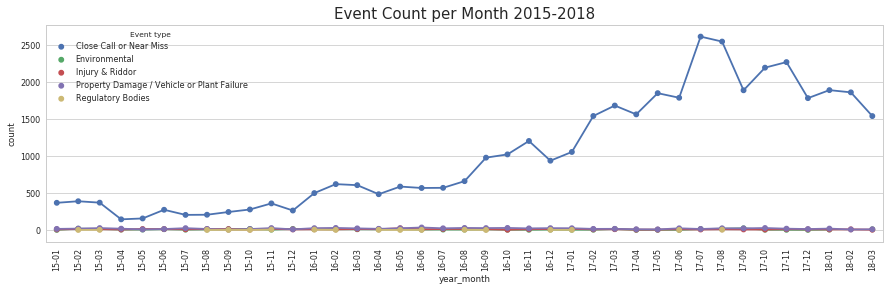

In [188]:
#event number per month 2015- 2018
ax = plt.figure(figsize = (15,4))
sns.pointplot(x='year_month', y ='count' ,
              data = EventSeasonal, hue ='Event type', order = year_month_order, estimator = np.sum,# markers = 'None'
              )
plt.title('Event Count per Month 2015-2018', fontsize = 15)
plt.xticks(rotation = 90)
plt.show()


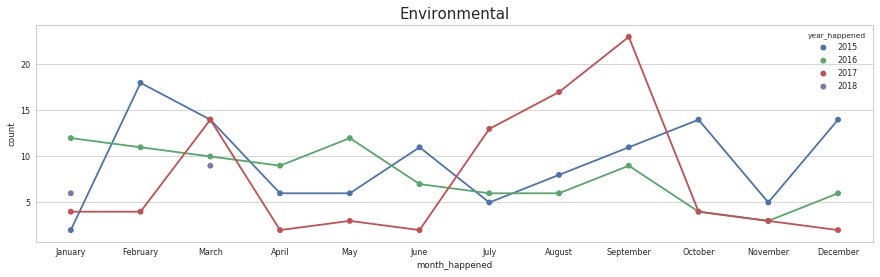

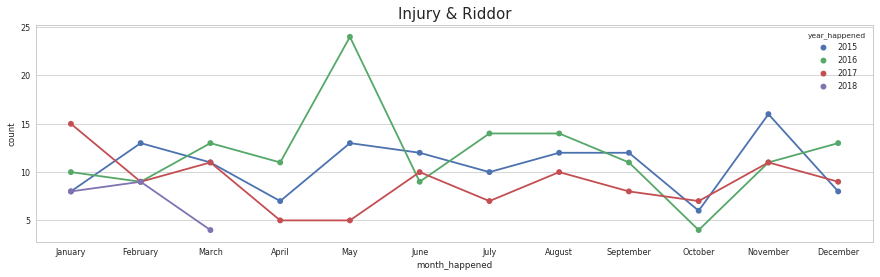

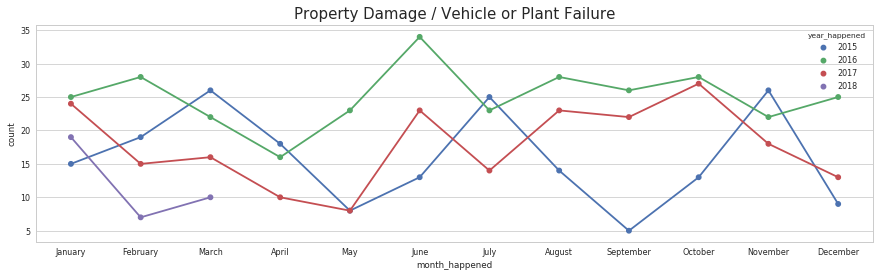

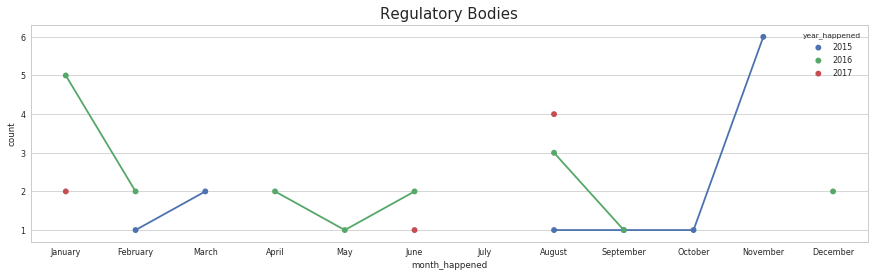

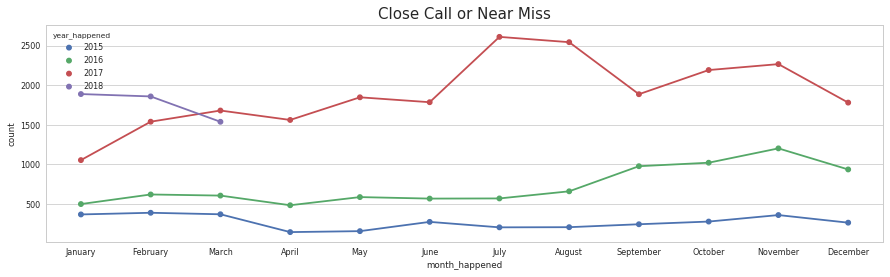

In [189]:
#see if real incidents are seasonal (not seasonal)['Environmental', 'Injury & Riddor', 
#'Property Damage / Vehicle or Plant Failure', 'Regulatory Bodies', 'sum']
def event_seasonal(df, event_type):
    ax = plt.figure(figsize = (15,4))
    sns.pointplot(x='month_happened', y ='count' ,
              data = df.loc[df['Event type'] == event_type], hue ='year_happened', order = monthorder, #markers = 'None'
              )
    plt.title(event_type, fontsize = 15)
    plt.show()
event_seasonal(EventSeasonal, 'Environmental')
event_seasonal(EventSeasonal, 'Injury & Riddor')
event_seasonal(EventSeasonal, 'Property Damage / Vehicle or Plant Failure')
event_seasonal(EventSeasonal, 'Regulatory Bodies')
event_seasonal(EventSeasonal, 'Close Call or Near Miss')

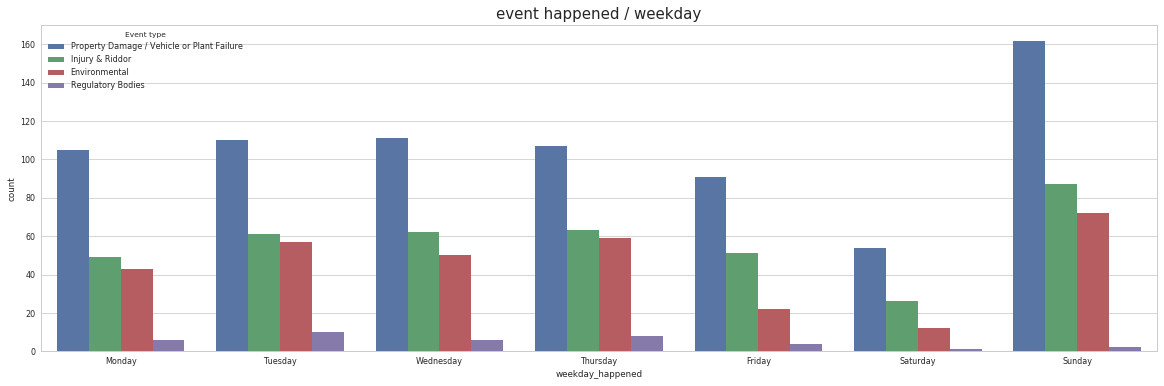

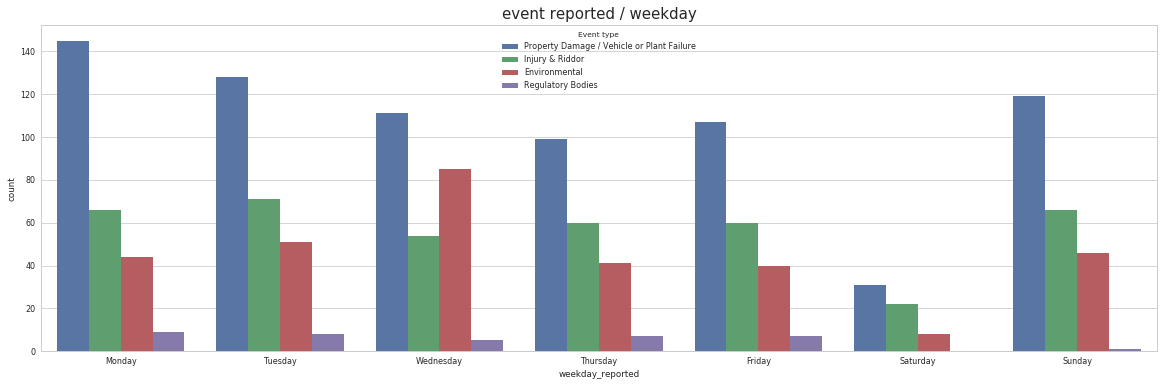

In [57]:
#plot happened event type for weekday
ax = plt.figure(figsize = (20,6))
sns.countplot(x='weekday_happened', #y = ,
              data = data.loc[data['Event type'] != 'Close Call or Near Miss'], hue ='Event type',
              order = ['Monday','Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday'])
#ax.set_xticklabels(ax2.get_xticklabels(),rotation=45)
#plt.xticks(rotation = 90)
plt.title('event happened / weekday', fontsize = 15)
plt.show()

#plot reported event type for weekday
ax = plt.figure(figsize = (20,6))
sns.countplot(x='weekday_reported', #y = ,
              data = data.loc[data['Event type'] != 'Close Call or Near Miss'], hue ='Event type',
              order = ['Monday','Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday'])
#ax.set_xticklabels(ax2.get_xticklabels(),rotation=45)
#plt.xticks(rotation = 90)
plt.title('event reported / weekday', fontsize = 15)
plt.show()

In [97]:
#c.loc[['Monday','Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday']]
c.set_index('index',inplace = True)
c = c.loc[['Monday','Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday']].reset_index()
c

,weekday_happened
index,
Wednesday,6979
Tuesday,6898
Thursday,6357
Sunday,6352
Monday,6147
Friday,3986
Saturday,3259


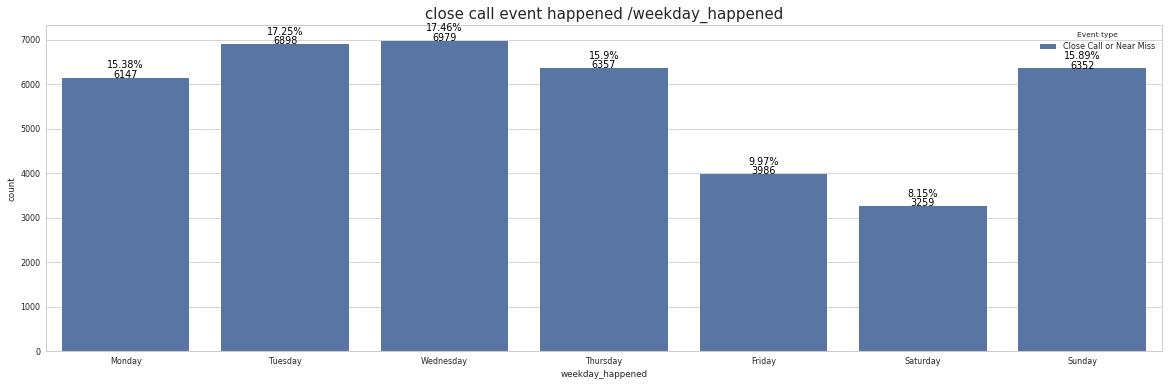

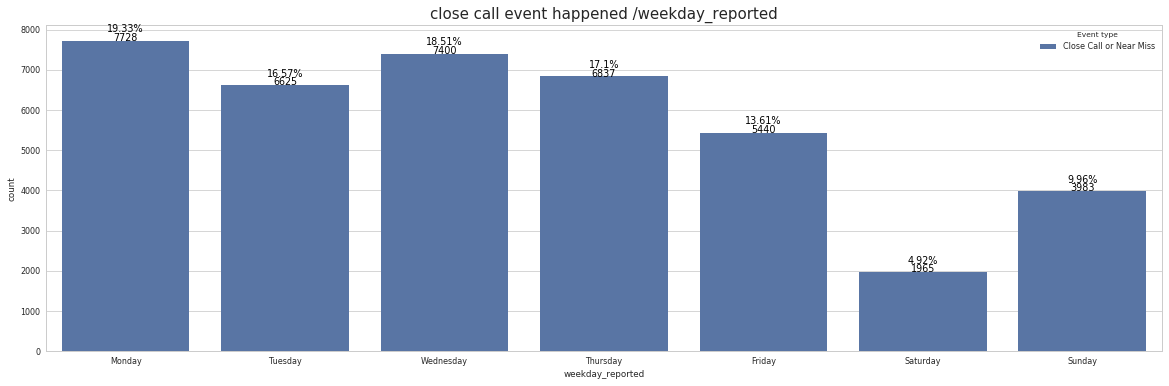

In [106]:
#plot happened/reported close call for weekday
def miss_call_wkday_plot(data, weekday_column):
    ax = plt.figure(figsize = (20,6))
    g = sns.countplot(x= weekday_column, #y = ,
              data = data.loc[data['Event type'] == 'Close Call or Near Miss'], hue ='Event type',
              order = ['Monday','Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday'])
    df = data.loc[data['Event type'] == 'Close Call or Near Miss']
    #adding numbers on diagram
    c = df[weekday_column].value_counts().reset_index()
    c.set_index('index',inplace = True)
    c = c.loc[['Monday','Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday']].reset_index()
    t = df[weekday_column].value_counts().sum() # total number of event
    for index, row in c.iterrows():
        g.text(index, row[weekday_column] , str(row[weekday_column]), color = 'black', ha = 'center')
        g.text(index,row[weekday_column]+210, str(((row[weekday_column]/t)*100).round(2))+'%', color='black', ha="center")
    #plt.xticks(rotation = 90)
    plt.title('close call event happened /'+ weekday_column, fontsize = 15)
    plt.show()

miss_call_wkday_plot(data,'weekday_happened')
miss_call_wkday_plot(data,'weekday_reported')


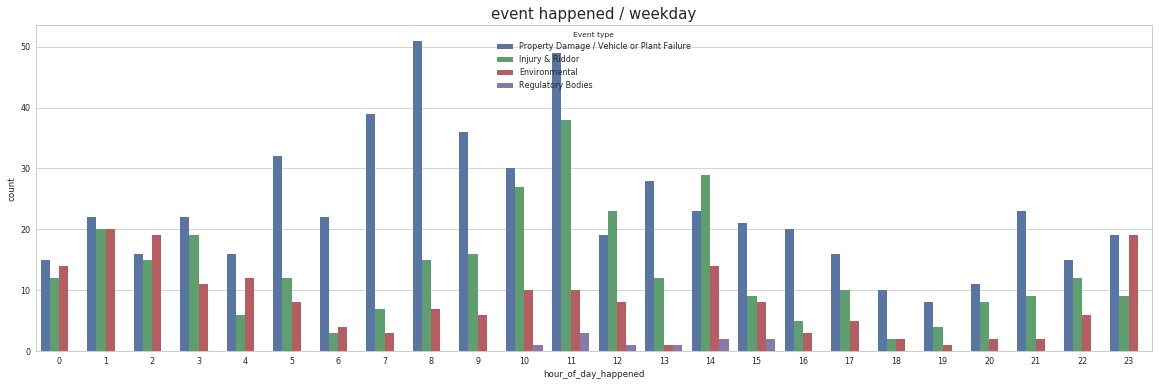

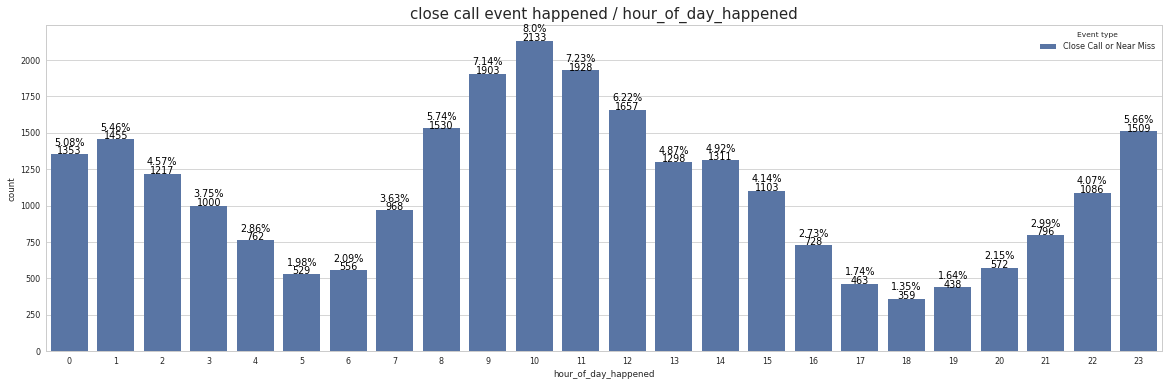

In [187]:
#get the order of hour of the day
hourorder = data['hour_of_day_happened'].unique()
hourorder.sort()

#plot happened/reported real incidents for hours of the day
ax = plt.figure(figsize = (20,6))
sns.countplot(x='hour_of_day_happened', #y = ,
              #data = data.loc[data['Event type'] != 'Close Call or Near Miss'],
              #remove 00:00
              data = data.loc[(data['Event type'] != 'Close Call or Near Miss') & (data['time_happened'] != datetime.time(0, 0))],
              hue ='Event type', order = hourorder)
plt.title('event happened / weekday', fontsize = 15)
plt.show()

def miss_call_hour_plot(data, weekday_column,hourorder):
    ax = plt.figure(figsize = (20,6))
    g = sns.countplot(x= weekday_column, #y = ,
              data = data.loc[data['Event type'] == 'Close Call or Near Miss'], hue ='Event type',
              order = hourorder)
    df = data.loc[data['Event type'] == 'Close Call or Near Miss']
    #adding numbers on diagram
    c = df[weekday_column].value_counts().reset_index()
    c.set_index('index',inplace = True)
    c = c.loc[hourorder].reset_index()
    t = df[weekday_column].value_counts().sum() # total number of event
    for index, row in c.iterrows():
        g.text(index, row[weekday_column] , str(row[weekday_column]), color = 'black', ha = 'center')
        g.text(index,row[weekday_column]+60, str(((row[weekday_column]/t)*100).round(2))+'%', color='black', ha="center")
    #plt.xticks(rotation = 90)          +400 if full data
    plt.title('close call event happened / '+ weekday_column, fontsize = 15)
    plt.show()

miss_call_hour_plot(data.loc[data['time_happened'] != datetime.time(0, 0)],'hour_of_day_happened',hourorder)
#                   data if full data

#plot happened/reported close call for hours of the day

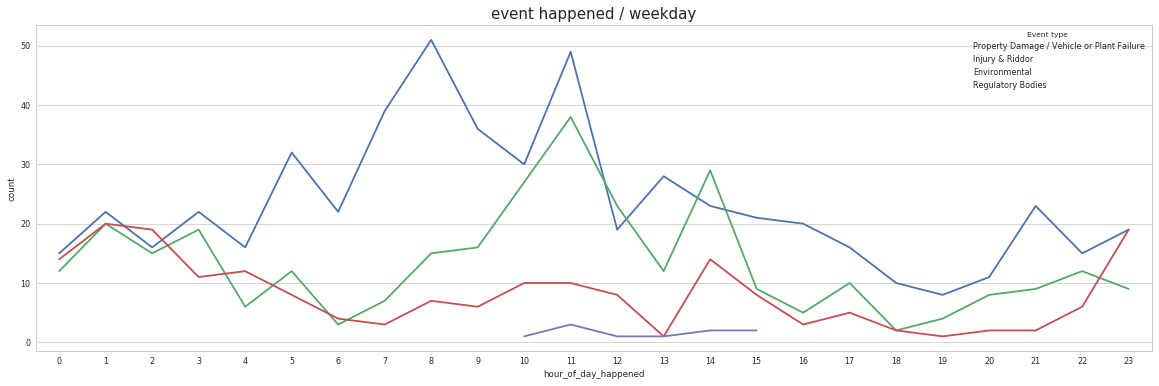

In [184]:
ax = plt.figure(figsize = (20,6))
sns.pointplot(x='hour_of_day_happened', y = 'count' ,
              #data = data.loc[data['Event type'] != 'Close Call or Near Miss'],
              #remove 00:00
              data = pd.DataFrame({'count': data.loc[(data['Event type'] != 'Close Call or Near Miss') & (data['time_happened'] != datetime.time(0, 0))].groupby(['hour_of_day_happened','Event type']).size()}).reset_index(),
              hue ='Event type', order = hourorder, ci = 'sd', markers = 'None',
              hue_order = ['Property Damage / Vehicle or Plant Failure', 'Injury & Riddor', 'Environmental', 'Regulatory Bodies'])
plt.title('event happened / weekday', fontsize = 15)
plt.show()

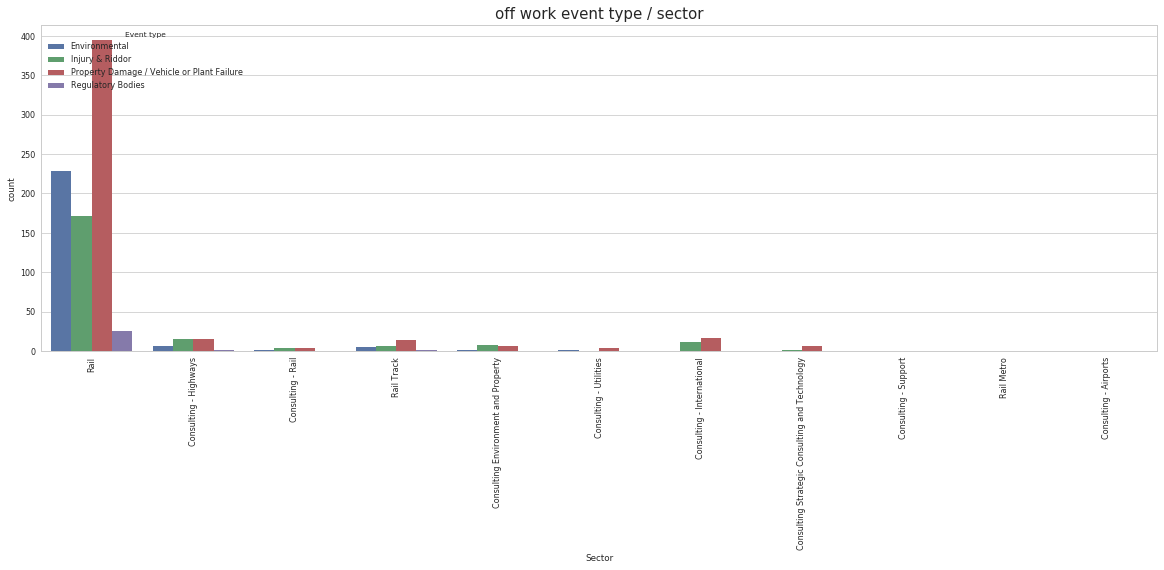

In [181]:
# Site / account and event type for off work hours
data_offwork = data.loc[( data['time_happened'] <= datetime.time(8,0)) | (data['time_happened'] >= datetime.time(18, 0))]
#plot off work hour happened incidents type for differnet areas in business
ax = plt.figure(figsize = (20,6))
sns.countplot(x='Sector', #y = ,
              hue ='Event type', 
              #data = data.loc[data['Event type'] != 'Close Call or Near Miss'],
              #remove 00:00
              data = data_offwork.loc[data_offwork['Event type'] != 'Close Call or Near Miss'] ,
              order = data_offwork['Sector'].value_counts().reset_index()['index'],
              hue_order = ['Environmental','Injury & Riddor','Property Damage / Vehicle or Plant Failure','Regulatory Bodies'])
plt.title('off work event type / sector', fontsize = 15)
plt.xticks(rotation = 90)
plt.show()

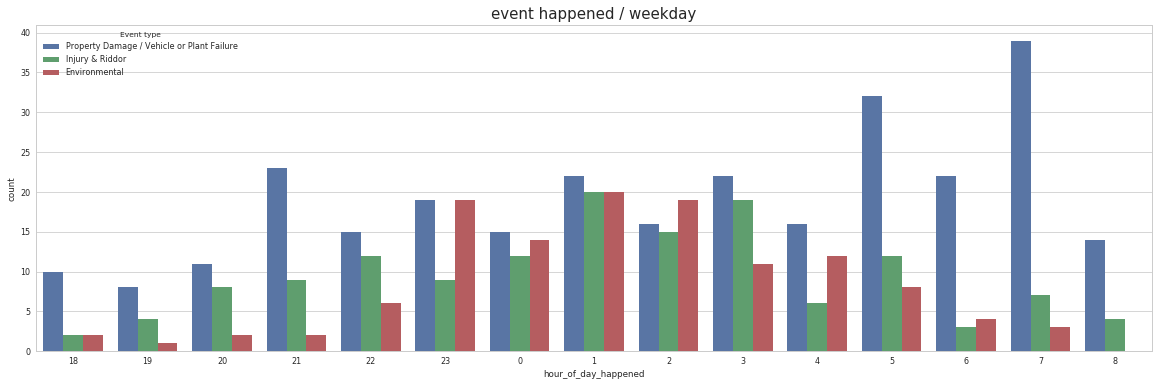

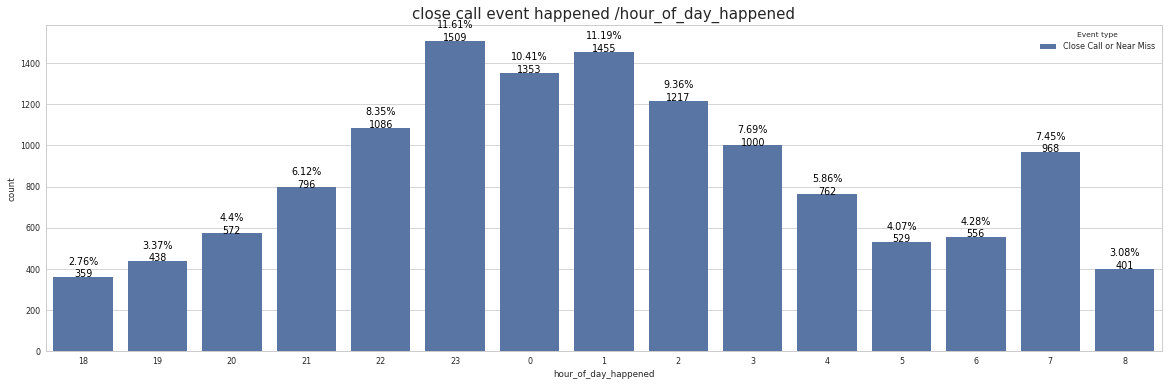

In [186]:
offhourorder = [18,19,20,21,22,23,0,1,2,3,4,5,6,7,8]
#plot happened/reported real incidents for hours of the day
ax = plt.figure(figsize = (20,6))
sns.countplot(x='hour_of_day_happened', #y = ,
              #data = data.loc[data['Event type'] != 'Close Call or Near Miss'],
              #remove 00:00
              data = data_offwork.loc[(data_offwork['Event type'] != 'Close Call or Near Miss') & (data_offwork['time_happened'] != datetime.time(0, 0))],
              hue ='Event type', order = offhourorder)
plt.title('event happened / weekday', fontsize = 15)
plt.show()

def miss_call_hour_plot(data, weekday_column,hourorder):
    ax = plt.figure(figsize = (20,6))
    g = sns.countplot(x= weekday_column, #y = ,
              data = data.loc[data['Event type'] == 'Close Call or Near Miss'], hue ='Event type',
              order = hourorder)
    df = data.loc[data['Event type'] == 'Close Call or Near Miss']
    #adding numbers on diagram
    c = df[weekday_column].value_counts().reset_index()
    c.set_index('index',inplace = True)
    c = c.loc[hourorder].reset_index()
    t = df[weekday_column].value_counts().sum() # total number of event
    for index, row in c.iterrows():
        g.text(index, row[weekday_column] , str(row[weekday_column]), color = 'black', ha = 'center')
        g.text(index,row[weekday_column]+60, str(((row[weekday_column]/t)*100).round(2))+'%', color='black', ha="center")
    #plt.xticks(rotation = 90)          +400 if full data
    plt.title('close call event happened /'+ weekday_column, fontsize = 15)
    plt.show()

miss_call_hour_plot(data_offwork.loc[data_offwork['time_happened'] != datetime.time(0, 0)],'hour_of_day_happened',offhourorder)
#                   data if full data


In [190]:
data.columns

Index(['Amey Plc (ALL)', 'System AI ID', 'Event type', 'Event subtype',
       'Who has reported this incident?',
       'Are you an operative/worker or supervisor?',
       'About the affected person', 'Type of person', 'UK Rail related?',
       'Which Company employs them if not Amey?', 'Date/time of incident',
       'Date/Time Reported', 'Business Unit', 'Sector', 'Contract',
       'Site / account', 'Where was it?', 'Location', 'Specific location?',
       'Do you work in the Railway part of Amey?', 'Contact telephone number',
       'Territory', 'Asset', 'Project number', 'Programme Manager',
       'Were you working alone?', 'Describe the task being done at the time',
       'Highway Work Breakdown Structure / Service',
       'Was affected person working alone?', 'Describe the incident:',
       'What did you see?', 'What could have happened?',
       'What were you able to do about it?', 'Were you at work or travelling?',
       'What were the lighting conditions?',
       'W

In [291]:
data['Investigation sign off date'].isnull().sum()

34402

In [265]:
##### 
data['Potential harm from'].value_counts()

S9 - Poor housekeeping/site cleanliness                                                         7685
F - Slip, trip or fall on same level                                                            6396
P - Incorrect use of / incorrect PPE                                                            2758
S6 - Lack of planning lock down/time pressure to deliver works on the railway                   2410
S - Railway possession irregularity                                                             1395
ZC - Inadequate welfare provision                                                               1365
A1 - Contact/near contact with moving machinery                                                 1322
S5 - Failure to sign in/out of rail work sites                                                  1049
C1 - Struck/nearly struck by moving vehicle (works area)                                         985
B - Struck/nearly struck by moving, flying or falling object                               